### Note:

Add code to save graphs in showPlot function



In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re  
import random
import numpy as np
import os
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import collections
from itertools import dropwhile
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
PATH = "data/"


In [3]:
#!pip3 install sacrebleu
from sacrebleu import corpus_bleu


In [4]:
#read in chinese-english pairs
#read in chinese-english pairs
lines_zh = open(PATH+'iwslt-zh-en/train.tok.zh',encoding = 'utf-8').read().strip().split('\n')
lines_en = open(PATH+'iwslt-zh-en/train.tok.en',encoding = 'utf-8').read().strip().split('\n')
lines_zh_test = open(PATH+'iwslt-zh-en/test.tok.zh',encoding = 'utf-8').read().strip().split('\n')
lines_en_test = open(PATH+'iwslt-zh-en/test.tok.en',encoding = 'utf-8').read().strip().split('\n')
lines_zh_val = open(PATH+'iwslt-zh-en/dev.tok.zh',encoding = 'utf-8').read().strip().split('\n')
lines_en_val = open(PATH+'iwslt-zh-en/dev.tok.en',encoding = 'utf-8').read().strip().split('\n')

In [5]:
def delect_least_common_words(list_sent, threshold = 5):
    ret_list =[]
    for x in list_sent:
        ret_list += x.split()
    ret_dic = collections.Counter(ret_list)
    
    #print (ret_dic["&amp;"])
    #print (ret_dic["&apos;"])
    #print (ret_dic["&quot;"])
    #print (ret_dic["&#91"])
    for key, count in dropwhile(lambda key_count: key_count[1] >= threshold, ret_dic.most_common()):
        
        del ret_dic[key]
        
        
    return list(ret_dic.keys())

In [6]:
zh_words = delect_least_common_words(lines_zh)
en_words = delect_least_common_words(lines_en)

In [7]:
len(zh_words)

34443

In [7]:
words_to_load = 100000
PAD_IDX = 0
UNK_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

with open(PATH+'cc.zh.300.vec') as f:
    loaded_embeddings_ft = np.zeros((words_to_load+3, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    ordered_words_ft.extend(['<pad>', '<unk>', '<s>'])
    loaded_embeddings_ft[0,:] = np.zeros(300)
    loaded_embeddings_ft[1,:] = np.random.normal(size = 300)
    loaded_embeddings_ft[2,:] = np.random.normal(size = 300)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft[i+3, :] = np.asarray(s[1:])
        words_ft[s[0]] = i+3
        idx2words_ft[i+3] = s[0]
        ordered_words_ft.append(s[0])
    length = len(np.setdiff1d(zh_words, ordered_words_ft))
    tmp_embeddings = np.zeros((length, 300))
    for idx, word in enumerate(np.setdiff1d(zh_words, ordered_words_ft)):
        words_ft[word] = idx+words_to_load+3
        idx2words_ft[idx+words_to_load+3] = word
        tmp_embeddings[idx, :] = np.random.normal(size = 300)
    loaded_embeddings_ft = np.concatenate((loaded_embeddings_ft, tmp_embeddings), axis = 0)
    words_ft['<pad>'] = PAD_IDX
    words_ft['<unk>'] = UNK_IDX
    words_ft['<s>'] = SOS_IDX
    idx2words_ft[PAD_IDX] = '<pad>'
    idx2words_ft[UNK_IDX] = '<unk>'
    idx2words_ft[SOS_IDX] = '<s>'
    
ordered_words_ft = list(words_ft.keys())

In [8]:
#English embedding
with open(PATH+'wiki-news-300d-1M.vec') as f:
    loaded_embeddings_ft_en = np.zeros((words_to_load+4, 300))
    words_ft_en = {}
    idx2words_ft_en = {}
    ordered_words_ft_en = []
    ordered_words_ft_en.extend(['<pad>', '<unk>', '<s>', '</s>'])
    loaded_embeddings_ft_en[0,:] = np.zeros(300)
    loaded_embeddings_ft_en[1,:] = np.random.normal(size = 300)
    loaded_embeddings_ft_en[2,:] = np.random.normal(size = 300)
    loaded_embeddings_ft_en[3,:] = np.random.normal(size = 300)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        loaded_embeddings_ft_en[i+4, :] = np.asarray(s[1:])
        words_ft_en[s[0]] = i+4
        idx2words_ft_en[i+4] = s[0]
        ordered_words_ft_en.append(s[0])
    length = len(np.setdiff1d(en_words, ordered_words_ft_en))
    tmp_embeddings = np.zeros((length, 300))
    for idx, word in enumerate(np.setdiff1d(en_words, ordered_words_ft_en)):
        words_ft_en[word] = idx+words_to_load+4
        idx2words_ft_en[idx+words_to_load+4] = word
        tmp_embeddings[idx, :] = np.random.normal(size = 300)
    loaded_embeddings_ft_en = np.concatenate((loaded_embeddings_ft_en, tmp_embeddings), axis = 0)
    words_ft_en['<pad>'] = PAD_IDX
    words_ft_en['<unk>'] = UNK_IDX
    words_ft_en['<s>'] = SOS_IDX
    words_ft_en['</s>'] = EOS_IDX
    idx2words_ft_en[PAD_IDX] = '<pad>'
    idx2words_ft_en[UNK_IDX] = '<unk>'
    idx2words_ft_en[SOS_IDX] = '<s>'
    idx2words_ft_en[EOS_IDX] = '</s>'
    
ordered_words_ft_en = list(words_ft_en.keys())

In [9]:
assert len(idx2words_ft) == len(words_ft)
assert len(loaded_embeddings_ft) == len(words_ft)
assert len(idx2words_ft_en) == len(words_ft_en)
assert len(loaded_embeddings_ft_en) == len(words_ft_en)
assert len(ordered_words_ft_en) == len(loaded_embeddings_ft_en)

In [10]:
#add sos and eos in each sentence
def add_sos_eos(lines):
    
    train = []
    for l in lines:
        l = '<s> ' + l + ' </s>'
        train.append(l)
    return train
zh_train = add_sos_eos(lines_zh)    
en_train = add_sos_eos(lines_en)
zh_test = add_sos_eos(lines_zh_test)
en_test = add_sos_eos(lines_en_test)
zh_val = add_sos_eos(lines_zh_val)
en_val = add_sos_eos(lines_en_val)

In [11]:
en_train[6]

'<s> And the problem , I think , is that we take the ocean for granted . </s>'

In [12]:
# convert token to id in the dataset
def token2index_dataset(tokens_data,eng = False):
    indices_data = []
    for tokens in tokens_data:
        index_list = []
        for token in tokens.split():
            if eng == False:
                try:
                    index_list.append(words_ft[token])
                except KeyError:
                    index_list.append(UNK_IDX)
            else:
                try:
                    index_list.append(words_ft_en[token])
                except KeyError:
                    index_list.append(UNK_IDX)
        indices_data.append(index_list)
    return indices_data

In [64]:
zh_train_indices = token2index_dataset(zh_train)
en_train_indices = token2index_dataset(en_train,eng = True)
zh_val_indices = token2index_dataset(zh_val)
en_val_indices = token2index_dataset(en_val,eng = True)
zh_test_indices = token2index_dataset(zh_test)
en_test_indices = token2index_dataset(en_test,eng = True)

In [14]:
#max_sentence_length
length_of_en = [len(x.split()) for x in en_train]
max_sentence_length_en = sorted(length_of_en)[-int(len(length_of_en)*0.01)]
length_of_zh = [len(x.split()) for x in zh_train]
max_sentence_length_zh = sorted(length_of_zh)[-int(len(length_of_zh)*0.01)]


In [15]:
max_sentence_length_en

74

In [15]:
#Create Data Loader
import torch
from torch.utils.data import Dataset

class load_dataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list_s1,data_list_s2):
        """
        @param data_list_zh: list of Chinese tokens 
        @param data_list_en: list of English tokens as TARGETS
        """
        self.data_list_s1 = data_list_s1
        self.data_list_s2 = data_list_s2
        
        assert (len(self.data_list_s1) == len(self.data_list_s2))

    def __len__(self):
        return len(self.data_list_s1)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx_s1 = self.data_list_s1[key][:max_sentence_length_zh]
        token_idx_s2 = self.data_list_s2[key][:max_sentence_length_en]
        return [token_idx_s1, token_idx_s2, len(token_idx_s1), len(token_idx_s2)]

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list_s1 = []
    data_list_s2 = []
    length_list_s1 = []
    length_list_s2 = []
    for datum in batch:
        length_list_s1.append(datum[2])
        length_list_s2.append(datum[3])
        padded_vec_zh = np.pad(np.array(datum[0]), 
                                pad_width=((0,max_sentence_length_zh-datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec_en = np.pad(np.array(datum[1]), 
                                pad_width=((0,max_sentence_length_en-datum[3])), 
                                mode="constant", constant_values=0)
        data_list_s1.append(padded_vec_zh[:max_sentence_length_zh])
        data_list_s2.append(padded_vec_en[:max_sentence_length_en])
    #print(type(data_list_s1[0]))
    
    return [torch.from_numpy(np.array(data_list_s1)).to(device), torch.from_numpy(np.array(data_list_s2)).to(device),
            torch.LongTensor(length_list_s1).to(device), torch.LongTensor(length_list_s2).to(device)]
    

In [65]:
BATCH_SIZE = 50
EMBEDDING_SIZE = 300 # fixed as from the input embedding data

train_dataset = load_dataset(zh_train_indices, en_train_indices)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=True)

val_dataset = load_dataset(zh_val_indices, en_val_indices)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)


test_dataset = load_dataset(zh_test_indices, en_test_indices)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=collate_func,
                                           shuffle=False)

### With Attention

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, emb_dim, hidden_size, embed= torch.from_numpy(loaded_embeddings_ft).float(),num_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.emb_dim = emb_dim
        self.num_layers = num_layers 

        self.embedding = nn.Embedding.from_pretrained(embed, freeze=False)
        #self.gru = nn.GRU(emb_dim, hidden_size,num_layers=num_layers,batch_first=True,bidirectional = True)
        self.rnn = nn.LSTM(self.emb_dim, self.hidden_size, batch_first = True,
                           num_layers=self.num_layers, bidirectional=True)

    def forward(self, data, hidden):
        #hidden is a tuple (h,c)
        #dimension of h: num_layers * num_directions, batch, hidden_size 
        
        batch_size, seq_len = data.size()
        
        embed = self.embedding(data)
        
        #print ("embed size",embed.shape)
        #output, hidden = self.gru(embed,hidden)
        
        #hidden is a tuple (h,c). Dim of h: num_layers * num_directions, batch, hidden_size
        output, (h,c) = self.rnn(embed,hidden)
        
        h = torch.sum(h, dim=0).unsqueeze(0)
        c = torch.sum(c, dim=0).unsqueeze(0)
        
        
        hidden = (h,c)
        
        #output = torch.cat((output[:, :, :self.hidden_size],
                #output[:, :, self.hidden_size:]),2)
        #print ("output size befre,",output.shape)
        #output =torch.cat((output[:, :, :self.hidden_size],
                #output[:, :, self.hidden_size:]),1)
        output = (output[:, :, :self.hidden_size] +
                output[:, :, self.hidden_size:])    
        #print ("output size after,",output.shape)
        #print ("output encoder ",output.shape)
        #print ("output size, ",output.shape)
        #print ("hidden size,", hidden[0].shape)
        ## potentially there are other ways 
        
        
        #hidden = [n layers * n directions =2 , batch_size, hidden_size ]
        #print ("encoder hidden",hidden)
        #print ("encoder output", output.shape)

        return output, hidden

    # initialize the hidden with random numbers
    def initHidden(self,batch_size):
        return (torch.randn(2*self.num_layers, batch_size, self.hidden_size,device=device),
                torch.randn(2*self.num_layers, batch_size, self.hidden_size,device=device))

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self,emb_dim,hidden_size, output_size, embed= torch.from_numpy(loaded_embeddings_ft_en).float(),num_layers=1,
                 dropout_p=0.1, max_length=max_sentence_length_zh):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding.from_pretrained(embed, freeze=False)
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size *2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.gru = nn.GRU(emb_dim, self.hidden_size)
        self.lstm = nn.LSTM(emb_dim, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, data, hidden,encoder_outputs):
        
        ### embed: [1 * batch size * emb_dim = 300 ] ###
        ### hidden: [1 * batch size * hidden_size = 300 ] ###
        ### encoder_outputs: [batch size * max_sentence_length_zh * hidden_size = 300 ] ###
        ### 因为这里concat之后，attn layer 他给的是 hidden size *2 
        ### 所以我这儿的hidden size就只能写300了 
        
        embed = self.embedding(data)
        embed = self.dropout(embed)
 
        ### torch.cat((embed, hidden), 2)  
        ### [1 * batch size * (emb_dim + hidden_size) ]
        
        ### attn_weights: [1 * batch size * max_sentence_length_zh ]###
        ### attn_weights[0].unsqueeze(1): [batch size * 1 * max_sentence_length_zh ]###
        
        ### softmax dim=2 因为最后一个dimension是 词组什么的，不能是1，1的话就是
        ### 不同batch间这样比较了？
        #hidden = [1 * batch_size * emb_dim]
        gru_out, hidden = self.lstm(embed, hidden)
#         attn_weights = F.softmax(
#             self.attn(torch.cat((embed[0], hidden[0]), 1)), dim=1).unsqueeze(1)
        attn_weights0 = self.attn(hidden[0]).transpose(0,1)
        attn_prod = torch.bmm(attn_weights0, encoder_outputs.transpose(1,2))
        ### torch.bmm(attn_weights[0].unsqueeze(1),encoder_outputs).squeeze(1) :
        ### [batch size * 1 * hidden_size ]###
        ### attn_applied: [batch size * hidden_size (= 300) ] ###
#         attn_applied = torch.bmm(attn_weights,
#                                  encoder_outputs).squeeze(1)
        ### output: [batch size * hidden_size (= 300) ] ###
        ### embed[0]: [batch size * hidden_size (= 300) ] ###
        attn_weights = F.softmax(attn_prod, dim = 2)
#         print(attn_weights.shape)
        context = torch.bmm(attn_weights, encoder_outputs)
        hc = torch.cat([hidden[0], context.transpose(0,1)], dim =2)
        out_hc = torch.tanh(self.attn_combine(hc))
        output = self.softmax(self.out(out_hc)[0])
#         output = torch.cat((embed[0], attn_applied), 1)
        ### output: [1 * batch size * hidden_size (= 300) ] ###
#         output = self.attn_combine(output).unsqueeze(0)
        ### output: [1 * batch size * hidden_size (= 300) ] ###
#         output = F.relu(output)
        
        #print(hidden.size())
        #print(output.size())

#         output, hidden = self.gru(output, hidden)
        
#         output = self.softmax(self.out(output[0]))
        
        return output, hidden, attn_weights

    def initHidden(self,batch_size):
        return torch.randn(self.num_layers, batch_size, self.hidden_size,device=device)

In [19]:
teacher_forcing_ratio = 1
#input_tensor: list of sentence tensor
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, eee):
    
    ### target_tensor [batch size, max_sentence_length_en = 377] ###
    ### target_tensor [batch size, max_sentence_length_zh = 220] ###
    batch_size_1, input_length = input_tensor.size()
    batch_size_2, target_length = target_tensor.size()
    #print ("target length ", target_length)
    
    
    encoder_hidden = encoder.initHidden(batch_size_1)
    h,c = encoder_hidden
    #print ("encoder hidden init, ",h.shape)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss = 0
    ### encoder_hidden: 1 * batch * hidden size ### 
    ### encoder_output: batch size * max_sentence_length_zh * hidden size ### 
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    #print ("encoder output, ", encoder_output.shape)

    decoder_input = torch.tensor(np.array([[SOS_IDX]]*batch_size_1).reshape(1,batch_size_1),device=device)
    decoder_hidden = encoder_hidden
    h1,c1 = encoder_hidden
    #print ("encoder hidden,", h1.shape)

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    #print(use_teacher_forcing)
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            
            ### decoder_output: [batchsize,5000] ###
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_output)
            
            #print ("decoder output, ",decoder_output.shape)
            #print ("target_tensor, ",len(target_tensor[:,di]))
            loss += criterion(decoder_output, target_tensor[:,di])
            decoder_input = target_tensor[:,di].unsqueeze(0)  # Teacher forcing
            
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden,encoder_output)
                        
            ### decoder_output [batch size, 50003]  ###
            
            ### topi is a [batch size, 1] tensor first we remove the size 1
            ### demension then we add it at the beginning using squeeze
            ### 有点脑残诶，做个转置不就好了？
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            
            ### decoder_input [1, batch size]  ###
            decoder_input = decoder_input.unsqueeze(0)
 
            loss += criterion(decoder_output, target_tensor[:,di])

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [20]:
from torch.optim.lr_scheduler import StepLR, LambdaLR
import pickle
def trainIters(encoder, decoder, n_iters, folder,lr_decrease = False,print_every=1, plot_every=100, evaluate_every = 50,read_in_model = False,learning_rate=0.001,early_stop_tol = 10e-7):
    start = time.time()
    plot_losses = []
    plot_val = []
    
    loss_history = []
   
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    patience = 0
    
    early_stopped = False
    current_best_bleu = 0
    
    best_encoder = encoder.state_dict()
    best_decoder = decoder.state_dict()
    
    
    #--------------------------------------------	
    #	
    #    LOAD MODELS	
    #	
    #--------------------------------------------	
    	
        
    
    if not os.path.exists(folder):	
        os.makedirs(folder)	

    if read_in_model == True:
        if os.path.exists(folder+'/Encoder'):	
            print('---------------------------------------------------------------------')	
            print('----------------Readind trained model---------------------------------')	
            print('---------------------------------------------------------------------')	

            #read trained models	
            encoder.load_state_dict(torch.load(folder+"/Encoder"))
            decoder.load_state_dict(torch.load(folder+"/Decoder"))	

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    if lr_decrease == True:
        encoder_scheduler = StepLR(encoder_optimizer, step_size=1, gamma=0.8)
        decoder_scheduler = StepLR(decoder_optimizer, step_size=1, gamma=0.8)
    
    
    criterion = nn.CrossEntropyLoss()
    #criterion_val = nn.CrossEntropyLoss()
    
    last_val = 0
    for iter in range(1, n_iters + 1):
        if lr_decrease == True:
            encoder_scheduler.step()
            decoder_scheduler.step()
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(train_loader):
            input_tensor = data_s1
            target_tensor = data_s2
            #print("train",target_tensor.size())
            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion,i)
            print_loss_total += loss
            plot_loss_total += loss

            if i % print_every == 0:
                if i != 0:
                    print_loss_avg = print_loss_total / print_every
                    print_loss_total = 0
                    print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                                 iter, iter / n_iters * 100, print_loss_avg))
                    loss_history.append(print_loss_avg)
                else:
                    print_loss_total = 0
                
            if i % plot_every == 0:
                if i != 0:
                    plot_loss_avg = plot_loss_total / plot_every
                    plot_losses.append(plot_loss_avg)
                    plot_loss_total = 0
                    
                    
                else:
                    plot_loss_total = 0
                
            if i % evaluate_every == 0:
                if i != 0:
                    bleu_score,output_words,attentions = evaluate(val_loader, encoder, decoder)
                    if bleu_score > current_best_bleu:
                        current_best_bleu = bleu_score
                        
                        best_encoder = copy.deepcopy(encoder.state_dict())
                        best_decoder = copy.deepcopy(decoder.state_dict())
                        
                    plot_val.append(bleu_score)
                    #print ("BLEU: ",bleu_score)
    # Save the model for every epoch
    print('---------------------------------------------------------------------')
    print('----------------Saving trained model---------------------------------')
    print('---------------------------------------------------------------------')               
    torch.save(best_encoder,folder +"/Encoder")
    torch.save(best_decoder,folder +"/Decoder")
    
                       
            
    with open(folder+"/loss_hist", 'wb') as f:
         pickle.dump(loss_history, f)
    with open(folder+"/bleu_hist", 'wb') as f:
         pickle.dump(plot_val, f)
    showPlot(plot_losses,title = "Train Loss",name = folder+"/loss.jpeg")
    showPlot(plot_val, title = "BLEU Score on Validation Set",name = folder+"/bleu.jpeg")
    return plot_losses




In [21]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points,title,name):
    plt.figure()
    
    plt.plot(points)
    plt.title(title)
    plt.savefig(name)
    
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [36]:
#loader can be test_loader or val_loader
def evaluate(loader, encoder, decoder, after_train_mode = False,beam = False, beam_k = 1):
    bleu_score_list = []
    big_pred_list = []
    big_ref_list = []
    with torch.no_grad():
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(loader):
            input_tensor = data_s1
            input_length = input_tensor.size()[0]
            #sentence_length to the output length
            sentence_length = data_s2.size()[1]
            encoder_hidden = encoder.initHidden(input_length)

            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
            
            #decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
            decoder_input = torch.tensor(np.array([[SOS_IDX]]*input_length).reshape(1,input_length),device=device)

            decoder_hidden = encoder_hidden

            decoder_attentions = torch.zeros(input_length,max_sentence_length_en, max_sentence_length_zh)
            decoded_words_eval = []
            sequences = [[list(), 1.0]]*input_length
            for di in range(sentence_length):
                decoded_words_sub = []
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_output)
                decoder_attentions[:,di,:] = decoder_attention.data.squeeze(1)
                # decoder_attentions[di] = decoder_attention.data
                # topk(1) - softmax probability maximum
                if beam == True:
                    pass
#                     topv, topi = decoder_output.data.topk(beam_k)
#                     #batch loop
#                     C = []
#                     for idx, ind in enumerate(topi):
#                         H, _ = sequences[idx]
#                         for ele in ind:
#                             if ele.item() == EOS_IDX:
#                                 H.append('<EOS>')
#                             else:
#                                 H.append(idx2words_ft_en[ele.item()])
                         
                else:
                    topv, topi = decoder_output.data.topk(1) 
                    
                #batch loop
                
                
                for ind in topi:
                    
                    if ind.item() == EOS_IDX:
                        
                        decoded_words_sub.append(idx2words_ft_en[EOS_IDX])
                        
                    else:
                        decoded_words_sub.append(idx2words_ft_en[ind.item()])
                    
                
                decoded_words_eval.append(decoded_words_sub)
                
                #swap dimensions of decoded_words to [batch_size * 377]
                
                #decoded_words_new = [[i for i in ele] for ele in list(zip(*decoded_words_eval))]

                #change the dimension
                decoder_input = topi.squeeze().detach()
                decoder_input = decoder_input.unsqueeze(0)
            
            
            pred_num = 0
            listed_predictions = []
            
            
            decoded_words_new = [[i for i in ele] for ele in list(zip(*decoded_words_eval))]
            
            for token_list in decoded_words_new:
                sent = ' '.join(str(token) for token in token_list if token!="<pad>" and token!="<s>" and token!="</s>")
                #print (sent)
                listed_predictions.append(sent)
                #print (sent)
                pred_num += 1
                
            ref_num = 0
            listed_reference = []
            for ele in data_s2:
                sent = index2token_sentence(ele)
                #print (tokens)
                #sent = ' '.join(tokens)
                #print (sent)
                listed_reference.append(sent)
                ref_num += 1
            
            big_pred_list += listed_predictions
            big_ref_list += listed_reference
            
            assert len(big_pred_list) == len(big_ref_list)
            
            
            #uncommon to print prediction and reference
            #print (listed_predictions)
            #print (listed_reference)
        bleu_score = corpus_bleu(big_pred_list,[big_ref_list]).score
        
        if after_train_mode == True:
            for idx,ele in enumerate(big_pred_list):
                print (ele)
                print (big_ref_list[idx])
                print ("\n")
                
                
    print('BLEU Score is %s' % (str(bleu_score)))
        

    return bleu_score, decoded_words_new, decoder_attentions
    
def index2token_batch(list_of_list):
    return ' '.join(idx2words_ft_en[r.item()] for v in list_of_list for r in v if r.item()!=PAD_IDX)
def index2token_sentence(sentence_batch):
    return ' '.join(idx2words_ft_en[sent.item()] for sent in sentence_batch if sent.item()!=PAD_IDX and sent.item()!=SOS_IDX and sent.item()!=EOS_IDX)

In [24]:
hidden_size = 300
encoder1 = EncoderRNN(EMBEDDING_SIZE,hidden_size).to(device)
decoder1 = AttnDecoderRNN(EMBEDDING_SIZE,hidden_size, len(ordered_words_ft_en)).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters(encoder1, decoder1, 20,'lstm_zh_h300_constlr001', 
           lr_decrease = False,print_every=50,plot_every = 100, evaluate_every = 250,
           read_in_model = False,learning_rate=0.001)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [40]:
#loader can be test_loader or val_loader
def evaluate_no_unk(loader, original_ref,encoder, decoder, after_train_mode = False,beam = False, beam_k = 1):
    bleu_score_list = []
    big_pred_list = []
    big_ref_list = []
    with torch.no_grad():
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(loader):
            input_tensor = data_s1
            input_length = input_tensor.size()[0]
            #sentence_length to the output length
            sentence_length = data_s2.size()[1]
            encoder_hidden = encoder.initHidden(input_length)

            encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
            
            #decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
            decoder_input = torch.tensor(np.array([[SOS_IDX]]*input_length).reshape(1,input_length),device=device)

            decoder_hidden = encoder_hidden

            decoder_attentions = torch.zeros(sentence_length, sentence_length)
            decoded_words_eval = []
            sequences = [[list(), 1.0]]*input_length
            
            decoder_attentions = torch.zeros(input_length,max_sentence_length_en, max_sentence_length_zh)
            #decoder_attentions = []
            for di in range(sentence_length):
                decoded_words_sub = []
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_output)
                
                decoder_attentions[:,di,:] = decoder_attention.data.squeeze(1)
                
               # decoder_attentions.append()
                # decoder_attentions[di] = decoder_attention.data
                # topk(1) - softmax probability maximum
                if beam == True:
                    pass
#                     topv, topi = decoder_output.data.topk(beam_k)
#                     #batch loop
#                     C = []
#                     for idx, ind in enumerate(topi):
#                         H, _ = sequences[idx]
#                         for ele in ind:
#                             if ele.item() == EOS_IDX:
#                                 H.append('<EOS>')
#                             else:
#                                 H.append(idx2words_ft_en[ele.item()])
                         
                else:
                    topv, topi = decoder_output.data.topk(1) 
                    
                #batch loop
                
                
                for ind in topi:
                    
                    if ind.item() == EOS_IDX:
                        
                        decoded_words_sub.append(idx2words_ft_en[EOS_IDX])
                        
                    else:
                        decoded_words_sub.append(idx2words_ft_en[ind.item()])
                    
                
                decoded_words_eval.append(decoded_words_sub)
                
                #swap dimensions of decoded_words to [batch_size * 377]
                
                #decoded_words_new = [[i for i in ele] for ele in list(zip(*decoded_words_eval))]

                #change the dimension
                decoder_input = topi.squeeze().detach()
                decoder_input = decoder_input.unsqueeze(0)
            
            
            pred_num = 0
            listed_predictions = []
            
            
            decoded_words_new = [[i for i in ele] for ele in list(zip(*decoded_words_eval))]
            
            for token_list in decoded_words_new:
                sent = ' '.join(str(token) for token in token_list if token!="<pad>" and token!="<s>" and token!="</s>")
                #print (sent)
                listed_predictions.append(sent)
                #print (sent)
                pred_num += 1
                
            ref_num = 0
            listed_reference = []
            for ele in data_s2:
                sent = index2token_sentence(ele)
                #print (tokens)
                #sent = ' '.join(tokens)
                #print (sent)
                listed_reference.append(sent)
                ref_num += 1
            
            big_pred_list += listed_predictions
            big_ref_list += listed_reference
            
            assert len(big_pred_list) == len(big_ref_list)
            
            
            #uncommon to print prediction and reference
            #print (listed_predictions)
            #print (listed_reference)
        
        bleu_score = corpus_bleu(big_pred_list,[original_ref]).score
        
        if after_train_mode == True:
            for idx,ele in enumerate(big_pred_list):
                print (ele)
                print (original_ref[idx])
                print ("\n")
                
                
    print('BLEU Score is %s' % (str(bleu_score)))
    
    

    return bleu_score, decoded_words_new, decoder_attentions
    
def index2token_batch(list_of_list):
    return ' '.join(idx2words_ft_en[r.item()] for v in list_of_list for r in v if r.item()!=PAD_IDX)
def index2token_sentence(sentence_batch):
    return ' '.join(idx2words_ft_en[sent.item()] for sent in sentence_batch if sent.item()!=PAD_IDX and sent.item()!=SOS_IDX and sent.item()!=EOS_IDX)

In [51]:
hidden_size = 200
encoder2 = EncoderRNN(EMBEDDING_SIZE,hidden_size).to(device)
decoder2 = AttnDecoderRNN(EMBEDDING_SIZE,hidden_size, len(ordered_words_ft_en)).to(device)
encoder2.load_state_dict(torch.load("lstm_viet_h200_lrdecay/Encoder"))
decoder2.load_state_dict(torch.load("lstm_viet_h200_lrdecay/Decoder"))
score_list, output_words, attentions = evaluate(val_loader, 
                                                encoder2, 
                                                decoder2,
                                                after_train_mode =True)

When I was a little , I think the <unk> was the world &apos;s best country in the world , and I used to sing &quot; We have nothing to be at envy . &quot;
When I was little , I thought my country was the best on the planet , and I grew up singing a song called &quot; Nothing To Envy . &quot;


I was very proud of my country .
And I was very proud .


In school , we spend a lot of time learning about the rest of the European Union , but not studying the outside world outside the outside world , except for Korea , except for Korea , which is the enemy .
In school , we spent a lot of time studying the history of Kim <unk> , but we never learned much about the outside world , except that America , South Korea , Japan are the enemies .


Although I &apos;ve been asked to know , I don &apos;t know how the world is , but I think I will live in the <unk> , until it &apos;s all going to be the <unk> , until everything is completely changed .
Although I often wondered about the outside world , I

It &apos;s my gospel , when I &apos;m telling people , grow your own food .


Plant themselves in a way to print money .
Growing your own food is like printing your own money .


I have a heritage in the Far East .
See , I have a legacy in South Central .


I grew up there . I raised my sons .
I grew up there . I raised my sons there .


And I denied all I made part of the reality that was created , but it was made for me by some others . And I was my real interaction .
And I refuse to be a part of this manufactured reality that was manufactured for me by some other people , and I &apos;m manufacturing my own reality .


I &apos;m an artist .
See , I &apos;m an artist .


My art was my art . I grew up doing my work .
Gardening is my graffiti . I grow my art .


Same for the Old movement , for example , for the walls of my wall , and I , I , I , my <unk> training , a walk away .
Just like a graffiti artist , where they <unk> walls , me , I beautiful lawns , <unk> .


I use a garden that

In [23]:
# beam search + bleu score
def beam_search_decoder(data, k):
    sequences = [[list(), 1.0]]
    # walk over each step in sequence
    for row in data:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
            seq, score = sequences[i]
            for j in range(len(row)):
                candidate = [seq + [j], score * -log(row[j])]
                all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select top best
        sequences = ordered[:1]
    return sequences

In [24]:
class decoder_output_node:
    def __init__(self,parent, word_idx, prob_sum, isroot=False):
        self.parent = parent
        self.isroot = isroot
        self.children = []
        self.word_idx = word_idx
        self.prob_sum = prob_sum
    
    def get_children(self):
        '''
        return children
        '''
        return self.children
    
    def add_children(self, child):
        '''
        child: node
        '''
        self.children.append(child)
        return
    
    def get_parent(self):
        '''
        get parent of children
        '''
        return self.parent
    
    def get_word_idx(self):
        
        return self.word_idx
    
    def get_prob_sum(self):
        
        return self.prob_sum
    
    def is_root(self):
        return self.isroot


In [25]:
def return_sentence_sequence(child_node):
    if child_node.is_root():
        return [child_node.get_word_idx()]
    
    return return_sentence_sequence(child_node.get_parent())+[child_node.get_word_idx()]

In [26]:
def beam_search(beam_k, decoder_output, prob_sum = None, parent_node_list=None, vocab_size = len(idx2words_ft_en)):
    '''
    params:
    beam_k
    decoder_output: previous round decoder output
    parent_node_list: previous candidate word list (for only one candidate)
    
    return:
    list_of_best_k_nodes: best k nodes found in this iteration, list of list, first dim batch, second dim best k
    prob_with_sum: probabilistic matrix after sum+sortee 
    '''
    # if first word
    if parent_node_list is None:
        # initialize result
        prob_with_sum_sorted, word_idx_sorted = decoder_output.data.topk(beam_k)
        #print("ps",prob_with_sum_sorted)
        # add initialize tree list
        list_of_best_k_nodes = []
        batchsize = prob_with_sum_sorted.shape[0]
        for batch_i in range(batchsize):
            batch_i_tree_list = []
            for beam_i in range(beam_k):
                # add tree root node to list
                batch_i_tree_list.append(decoder_output_node(parent=None, word_idx= word_idx_sorted[batch_i, beam_i].item(), 
                                                            prob_sum= prob_with_sum_sorted[batch_i, beam_i].item(), isroot=True))
                
            list_of_best_k_nodes.append(batch_i_tree_list)
   
    # if not first word
    else:
        # get sorted results for all outputs
        prob = decoder_output.data
        #print(decoder_output.data.shape)
        #print(word_idx)
        
        
        # find top beam k words options
        #print("sum:",prob_sum)
        #print("curr prob:",prob)
        #print("sum:",prob+prob_sum)
        #print("in beam",prob_sum[0,:])
        
        prob_with_sum = prob+prob_sum
        #print("in beam prob", max(prob[0,:]))
        
        prob_with_sum_sorted, word_idx_sorted = torch.sort(prob_with_sum, dim=1, descending=True)
        #print("in beam prob max", prob_with_sum_sorted[0,0])
        #print("in beam prob second max", prob_with_sum_sorted[0,1])
        #print("sum sorted:", prob_with_sum_sorted)
        # add top beam k words options into tree
        batchsize = prob_with_sum_sorted.shape[0]
        
        list_of_best_k_nodes = []
        for batch_i in range(batchsize):
            batch_i_tree_list = []
            for beam_i in range(beam_k):
                #print(word_idx_sorted[batch_i, beam_i])
                #print(parent_node_list[batch_i].get_word_idx())
                child_node = decoder_output_node(parent=parent_node_list[batch_i], word_idx= word_idx_sorted[batch_i,beam_i].item(), prob_sum=prob_with_sum_sorted[batch_i,beam_i].item())
                
                # update parent node's child
                parent_node_list[batch_i].add_children(child_node)
                #save child to new list
                batch_i_tree_list.append(child_node)
            # add batch tree list to best k
            list_of_best_k_nodes.append(batch_i_tree_list)
                
    return list_of_best_k_nodes, prob_with_sum_sorted[:,:beam_k], word_idx_sorted[:,:beam_k]


In [32]:
def evaluate_with_beam_search(val_loader,original_ref,encoder1,decoder1,beam_k = 5, threshold_p=3):
    big_pred_list = []
    big_ref_list = []
    #beam_k = 5
    with torch.no_grad():
        #predictions = ''
        #references = ''
        for i, (data_s1, data_s2, lengths_s1, lengths_s2) in enumerate(val_loader):
            #print(i)
            input_tensor = data_s1
            input_length = input_tensor.size()[0]
            #sentence_length to the output length
            sentence_length = data_s2.size()[1]
            #print(sentence_length)
            encoder_hidden = encoder1.initHidden(input_length)

            encoder_output, encoder_hidden = encoder1(input_tensor, encoder_hidden)

            #decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
            decoder_input = torch.tensor(np.array([[SOS_IDX]]*input_length).reshape(1,input_length),device=device)

            decoder_hidden = encoder_hidden

            decoder_attentions = torch.zeros(sentence_length, sentence_length)
            #decoded_words_eval = []
            list_of_best_k_nodes = []

            prob_with_sum_sorted = []
            #print("outside",prob_with_sum_sorted)

            decoder_hidden_list = []
            decoder_cell_list = []
            
            # final candidate list
            ## batch_size lists in each list
            final_candidate_list = []
            for i in range(input_length):
                final_candidate_list.append([])
            num_of_can = [0]*input_length
            num_of_batch_reach_thre = 0
            #decoder_attentions = torch.zeros(input_length,max_sentence_length_en, max_sentence_length_zh)
            for di in range(sentence_length):

                ############################################beam search###################################################
                #print(di)
                if di == 0:
                    #decoded_words_sub = []


                    decoder_output, decoder_hidden, decoder_attention = decoder1(
                                decoder_input, decoder_hidden,encoder_output)

                    # find top k candidates
                    list_of_best_k_nodes,prob_with_sum_sorted ,word_idx_sorted = beam_search(beam_k, decoder_output, parent_node_list=None)
                    
                    for idx in range(beam_k):
                        decoder_hidden_list.append(copy.deepcopy(decoder_hidden[0].data))
                        
                    for idx in range(beam_k):
                        decoder_cell_list.append(copy.deepcopy(decoder_hidden[1].data))
                    #decoder_hidden_list = [copy.deepcopy(decoder_hidden.data)]*beam_k

                    #print("sum1",prob_with_sum_sorted)
                    #print("idx",word_idx_sorted)
                    #print(list_of_best_k_nodes[0][0].get_word_idx())
                    #print(list_of_best_k_nodes[0][1].get_word_idx())

                else:
                    # keep track of all new nodes
                    new_nodes = []
                    nodes_prob = None
                    #nodes_word_idx = None

                    # store index in previous candidate to locate position in new nodes, repeats=beam_size*beam_size
                    prev_candidate_idx = np.repeat(range(beam_k), repeats=beam_k)

                    # iterate through each node candidate from last iterations to find new candidates
                    new_decoder_hidden_list = []
                    new_decoder_cell_list = []
                    #print('di ', di)
                    #print('first beam', prob_with_sum_sorted[0,0])
                    #print('second beam', prob_with_sum_sorted[0,1])
                    for beam_i in range(beam_k):
                        #print(word_idx_sorted.shape)
                        topi = word_idx_sorted[:,beam_i].data
                        #print("idx i",topi)

                        prob_sum = prob_with_sum_sorted[:,beam_i].view((input_length,1))
                        #print("prob sum:", prob_sum[0,0])
                        #change the dimension
                        decoder_input = topi.squeeze().detach()
                        decoder_input = decoder_input.unsqueeze(0)

                        # get decoder output
                        decoder_output, decoder_hidden_i, decoder_attention = decoder1(
                                        decoder_input, (decoder_hidden_list[beam_i], decoder_cell_list[beam_i]),encoder_output)
                        
                        new_decoder_hidden_list.append(copy.deepcopy(decoder_hidden_i[0].data))
                        new_decoder_cell_list.append(copy.deepcopy(decoder_hidden_i[1].data))

                        # get beam search output
                        best_k_curr_node, prob_sum_curr_node, _ = beam_search(beam_k, decoder_output, prob_sum=prob_sum, parent_node_list=[ls[beam_i] for ls in list_of_best_k_nodes])
                        #print(word_idx_curr_node)
                        #print("current max first beam", prob_sum_curr_node[0,0])
                        #print("current max second beam", prob_sum_curr_node[0,1])
                        
                        # keep track of beam search output
                        new_nodes.append(best_k_curr_node)

                        if beam_i == 0:
                            nodes_prob = prob_sum_curr_node.data
                            #nodes_word_idx = word_idx_curr_node
                        else:
                            nodes_prob = torch.cat((nodes_prob, prob_sum_curr_node.data),dim=1)
                            #nodes_word_idx = torch.cat((nodes_word_idx, word_idx_curr_node),dim=1)

                    #print("nodes prob", nodes_prob)
                    _, sorted_idx = torch.sort(nodes_prob, dim=1, descending=True)
                    #print("nodes prob", nodes_prob[0,sorted_idx[0,0]].item())
                    #print("length",nodes_prob.shape)
                    #print(nodes_prob)
                    #print(sorted_idx)

                    #print(prev_candidate_idx)
                    #print("new nodes len:", len(new_nodes[0][0]))
                    #print("new_nodes 0",new_nodes[0])
                    #print("new_nodes 1",new_nodes[1])
                    # update 
                    #print(sorted_idx.shape)
                    for batch_i in range(input_length):
                        for beam_i in range(beam_k):
                            # find the index of which candidate it descended from
                            st_idx = sorted_idx[batch_i][beam_i].item()
                            #if batch_i == 0:
                            #    print("st_idx", prev_candidate_idx[st_idx])
                            #    print(new_decoder_hidden_list[prev_candidate_idx[st_idx]][:,batch_i,:])
                            #print("st_idx", prev_candidate_idx[st_idx])
                            # find the corresponding node, st_idx gives parent node id, batch_i gives which example, st_idx%beam_k gives which node in the existing node list
                            #if batch_i == 0:
                            #print("st_idx",st_idx)
                            update_node = new_nodes[prev_candidate_idx[st_idx]][batch_i][st_idx%beam_k]

                            list_of_best_k_nodes[batch_i][beam_i] = update_node
                            #print(batch_i)
                            #print(beam_i)
                            #print(list_of_best_k_nodes[0][0].parent.get_word_idx())

                            # update word idex, prob sum correspondingly for next iteration
                            #word_idx_sorted[batch_i][beam_i] = nodes_word_idx[batch_i][st_idx] 
                            word_idx_sorted[batch_i,beam_i] = update_node.get_word_idx()
                            prob_with_sum_sorted[batch_i,beam_i] = update_node.get_prob_sum()
                            decoder_hidden_list[beam_i][:,batch_i,:] = new_decoder_hidden_list[prev_candidate_idx[st_idx]][:,batch_i,:]
                            decoder_cell_list[beam_i][:,batch_i,:] = new_decoder_cell_list[prev_candidate_idx[st_idx]][:,batch_i,:]
                            
                            if (update_node.get_word_idx() == EOS_IDX):
                                prob_with_sum_sorted[batch_i,beam_i] = float("-inf")
                                update_node.prob_sum = update_node.get_prob_sum()/(di+1)
                                final_candidate_list[batch_i].append(update_node)
                                num_of_can[batch_i]+=1
                                if num_of_can[batch_i] == threshold_p:
                                    num_of_batch_reach_thre += 1
                    
                    if num_of_batch_reach_thre == input_length:
                        break
                                
                    #print(list_of_best_k_nodes[0][0].get_prob_sum())
                    #print(list_of_best_k_nodes[0][0].get_word_idx())
                    #print(word_idx_sorted[0,0])
                    #print(decoder_hidden_list[1])
                    #print(decoder_hidden_list[0])
                    #print("di", di)
                    #print("best k",list_of_best_k_nodes[0])
                    #print("final", prob_with_sum_sorted)
                    #print("idx final", word_idx_sorted)
            
            #print(final_candidate_list[0][0])
            #print(final_candidate_list[1][0])
            #print(num_of_can)
            # find the best and get index
            listed_predictions = []
            for batch_i in range(input_length):
                if num_of_can[batch_i] >= threshold_p:
                    best_sequence_last_node = max(final_candidate_list[batch_i], key=lambda c: c.get_prob_sum())
                else:
                    best_sequence_last_node_noneos = None
                    for sub_i in range(beam_k):
                        best_sequence_last_node_noneos_i = list_of_best_k_nodes[batch_i][sub_i]
                        if best_sequence_last_node_noneos_i.get_word_idx() != EOS_IDX:
                            best_sequence_last_node_noneos_i.prob_sum = best_sequence_last_node_noneos_i.get_prob_sum()/sentence_length
                            best_sequence_last_node_noneos = best_sequence_last_node_noneos_i
                            break
                    if best_sequence_last_node_noneos is None:
                        raise ValueError("something is wrong")
                    
                    best_sequence_last_node = max(final_candidate_list[batch_i]+[best_sequence_last_node_noneos], key=lambda c: c.get_prob_sum())
                    
                #print("batch i ", batch_i)
                #print("best sequence",best_sequence_last_node)
                #print("next best sequence",list_of_best_k_nodes[batch_i][1].get_prob_sum())
                batch_i_word_idx = return_sentence_sequence(best_sequence_last_node)
                
                try:
                    first_ed_idx = batch_i_word_idx.index(EOS_IDX)
                except:
                    first_ed_idx = len(batch_i_word_idx)
                
                listed_predictions.append(' '.join(idx2words_ft_en[token_idx] for token_idx in batch_i_word_idx[:first_ed_idx] if (token_idx!=PAD_IDX and token_idx!=SOS_IDX and token_idx!=EOS_IDX)))
                #print(' '.join(idx2words_ft_en[token_idx] for token_idx in batch_i_word_idx ))
                #print(batch_i_word_idx)
                #print (listed_predictions)
            listed_reference = []
            for ele in data_s2:
                sent = index2token_sentence(ele)

                listed_reference.append(sent)
                #print ("\n")
                #print (sent)

            #print(listed_predictions)
            #bleu_score = corpus_bleu(listed_predictions,[listed_reference])
            #print('BLEU Score is %s' % (str(bleu_score.score)))

            big_pred_list += listed_predictions
            big_ref_list += listed_reference
            
            for idx,ele in enumerate(big_pred_list):
                print (ele)
                print (original_ref[idx])
                print ("\n")
                
            #break
            
    bleu_score = corpus_bleu(big_pred_list,[original_ref])
    print('BLEU Score is %s' % (str(bleu_score.score)))
            ############################################beam search###################################################
    return bleu_score

In [61]:
evaluate_with_beam_search(val_loader,lines_en_val,encoder1,decoder1,beam_k = 4, threshold_p=4)

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

It &apos;s the <unk> , and they all come together , and they all come together for 100 years later in New York City , and their conclusion will not be 100 years later .
And in 1860 , this group of people came together , and they all speculated about what would happen to the city of New York in 100 years , and the conclusion was unanimous : The city of New York would not exist in 100 years .


Why ? Because they &apos;re looking at the curve , and if the population continues to grow , the people in New York will require that the waste of six million horses , six million horses , and the manure of the horse does not work .
Why ? Because they looked at the curve and said , if the population keeps growing at this rate , to move the population of New York around , they would have needed six million horses , and the manure created by six million horses would be impossible to deal with .


People are going to be drowned .
They were already drowning in manure .


So in 1860 , they saw this dir

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

You have to tell them entrepreneurship .
And then you have to tell them the truth about entrepreneurship .


Whether it &apos;s a big company , or some companies do have three things that are good , quality , quality , quality , marketing , <unk> financial management , you need to be brilliant , financial management , you need to be savvy .
The smallest company , the biggest company , has to be capable of doing three things beautifully : The product that you want to sell has to be fantastic , you have to have fantastic marketing , and you have to have tremendous financial management .


What &apos;s the problem ?
Guess what ?


There &apos;s no one person in the world who is able to produce sales and financial work at the same time .
We have never met a single human being in the world who can make it , sell it and look after the money .


It doesn &apos;t exist .
It doesn &apos;t exist .


That &apos;s the great majority of the world .
This person has never been born .


We &apos;ve do

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

That &apos;s the equivalent of five billion dollars today .
That equates to about $ 50,000 in today &apos;s money .


But today , the cost of being domesticated is probably 1.8 billion times a year .
Yet today , entire families can be enslaved for generations over a debt as small as $ 18 .


It was astonishing that the profits were over 150 million dollars a year on the global profits .
Astonishingly , slavery generates profits of more than $ 13 billion worldwide each year .


And many of them are being deceived , committed to good education opportunities , such opportunity , not a good job , to be forced to support the violence and not escape from it .
Many have been tricked by false promises of a good education , a better job , only to find that they &apos;re forced to work without pay under the threat of violence , and they cannot walk away .


Now , slavery is about the value of business interests , the goods that make slavery , but the value of creating the value of the people .
T

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch

You don &apos;t need to design a series of new hospitals .
You don &apos;t have to design a whole new set of hospitals to do it .


And they &apos;re also accurate , although it says , &quot; But it &apos;s not an expert on happiness . &quot;
And they &apos;re both accurate . Okay , but in addition , voice-based tests are non-expert .


That means that patients can do it .
That means they can be self-administered .


It &apos;s going to be 30 seconds , and it &apos;s about 30 seconds .
They &apos;re high-speed , take about 30 seconds at most .


Prices were low , and we knew how to do this .
They &apos;re ultra-low cost , and we all know what happens .


And it can be incredibly scalable .
When something becomes ultra-low cost , it becomes massively scalable .


I &apos;m here for the great goal of the great goal .
So here are some amazing goals that I think we can deal with now .


We can reduce the problem with the patient .
We can reduce logistical difficulties with patients .


The

When I was 11 years old , I remember one day wake up to hear the joy of the house .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his &quot; The Grey , &quot; and the BBC listened to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most of the news was only made him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took their father , loudly .
&quot; The Taliban are gone ! &quot; my father shouted .


I don &apos;t know what that means , but I can tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout . &quot;
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .


A real sch




They squirt the fuel in the <unk> fuel , and then they go in , and they &apos;re toxic in the dye , and they &apos;re toxic .
They mix dye in these big barrels , and they submerge the silk into the liquid up to their elbows , but the dye is toxic .


The translator told me their story .
My interpreter told me their stories .


We don &apos;t have freedom . They said .
&quot; We have no freedom , &quot; they said .


But we want to get out of this room where we can get away from this room to other parts of the room .
&quot; We hope still , though , that we could leave this house someday and go someplace else where we actually get paid for our dyeing . &quot;


It &apos;s estimated that there &apos;s more than 4,000 children in Walter Reed , the vehicle of the world , which is the largest <unk> in the world .
It &apos;s estimated that more than 4,000 children are enslaved on Lake Volta , the largest man-made lake in the world .


We went there , and I went to a point .
When we first a

BLEU Score is 15.457701905526937


BLEU(score=15.457701905526937, counts=[13914, 6097, 3151, 1729], totals=[31920, 30659, 29398, 28138], precisions=[43.590225563909776, 19.886493362471054, 10.718416218790393, 6.14471533158007], bp=1.0, sys_len=31920, ref_len=29261)

In [28]:
hidden_size = 300
encoder1 = EncoderRNN(EMBEDDING_SIZE,hidden_size).to(device)
decoder1 = AttnDecoderRNN(EMBEDDING_SIZE,hidden_size, len(ordered_words_ft_en)).to(device)

encoder1.load_state_dict(torch.load("lstm_zh_h300_constlr001_new/Encoder"))
decoder1.load_state_dict(torch.load("lstm_zh_h300_constlr001_new/Decoder"))

In [ ]:
hidden_size = 300
encoder1 = EncoderRNN(EMBEDDING_SIZE,hidden_size).to(device)
decoder1 = AttnDecoderRNN(EMBEDDING_SIZE,hidden_size, len(ordered_words_ft_en)).to(device)

encoder1.load_state_dict(torch.load("lstm_vi_h300_constlr001_new/Encoder"))
decoder1.load_state_dict(torch.load("lstm_zh_h300_constlr001_new/Decoder"))

In [66]:
evaluate_with_beam_search(test_loader,lines_en_test,encoder1,decoder1,beam_k = 3, threshold_p=3)

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

How could we help you ? &quot;


I think we &apos;re willing to think that this is one of the major reasons that we fail to think about , and one of the major reasons that we don &apos;t listen to .
And we think , we like to think , that this is one of the major problems why all -- maybe not all -- but most of the e-health projects fail , since we stopped listening .


This is my Wi-Fi weight measurements . It &apos;s a very simple thing .
This is my WiFi scale . It &apos;s a very simple thing .


There &apos;s a switch .
It &apos;s got one knob , on / off .


Every morning I got up and weigh it .
And every morning I hop on it .


&quot; Aha , &quot; I set myself a target .
And yes , I &apos;ve got a challenge , as you might see .


I &apos;d put my weight on the body .
And I put my challenge on 95 kg .


In fact , the whole thing is very simple , and I &apos;m going to send my data to Google , and I &apos;ll send my data to Google .
But the thing is that it &apos;s made this simple th

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Something really weird is going on here .


That &apos;s basically what I &apos;m going to say next .
And that &apos;s basically what I &apos;m going to be talking about .


It &apos;s got to open up the lights .
So , if you could bring up the lights .


And I &apos;ll highlight the lights because I &apos;m going to use a paper .
If you could bring up the lights higher , because I &apos;m just going to use a piece of paper here .


Why do we use logarithmic curves ? The technology curve .
Now why do we draw technology curves in semi-log curves ?


Well , the answer is , if I painted the standard curve , this is a time that I &apos;m going to do , some of the technology that I &apos;m going to do , some of the stuff that I &apos;m going to do , some of the measurements that look a little silly .
Well the answer is , if I drew it on a normal curve where , let &apos;s say , this is years , this is time of some sort , and this is whatever measure of the technology that I &apos;m trying to 

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos

The unhealthy shame I &apos;m talking about is the one that makes you so sick inside .


It would say to you , &quot; No , it &apos;s not what you &apos;re doing , but you are the bad guys . &quot;
It &apos;s the one that says , not that what you did was bad , but that you are bad .


That &apos;s what I felt like .
And it was what I was feeling .


And that &apos;s not because my own own personal mind is very good .
And it wasn &apos;t because of my attending ; he was a doll .


He was talking about me and he was going to talk about me , and he was going to make sure that I didn &apos;t have a accused for me .
He talked to the family , and I &apos;m quite sure that he smoothed things over and made sure that I didn &apos;t get sued .


But I kept asking myself .
And I kept asking myself these questions .


Why did I have no contact with my head ? Why did I let her go home ?
Why didn &apos;t I ask my attending ? Why did I send her home ?


I was even more depressed , and I would ask , &

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos


Sounds strange , right ?
Somehow this isn &apos;t working out , is it ?


If you live in a region where you live in a remote region , and you love the two artery you love , your family doctors , the doctors , will recommend a cardiologist in surgery , which has a <unk> heart rate .
Now suppose you live in a certain part of a certain remote place and you have a loved one who has blockages in two coronary arteries and your family doctor refers that loved one to a cardiologist who &apos;s batting 200 on angioplasties .


But you know what ?
But , but , you know what ?


Her performance had a huge increase in her performance this year .
She &apos;s doing a lot better this year . She &apos;s on the comeback trail .


Her exhalation rate , her rate , goes to five .
And she &apos;s hitting a 257 .


But it &apos;s not acceptable .
Somehow this isn &apos;t working .


I &apos;m going to ask you a question now .
But I &apos;m going to ask you a question .


Do you think a cardiologist doctor o

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos



This is a <unk> program that lets you pick up a <unk> program .
It &apos;s a cute little app where you can adopt a fire hydrant .


And you agreed to agree on the snow .
So you agree to dig it out when it snows .


If you do that , you can think of this as a name , and he &apos;s called the first one .
If you do , you get to name it , and he called the first one Al .


But if you don &apos;t scoop it up , you can take it from you .
And if you don &apos;t , someone can steal it from you .


So , it &apos;s a little bit of fun .
So it &apos;s got cute little game dynamics on it .


This is a relatively small program .
This is a modest little app .


And it &apos;s probably one group that was written by the team , 21 .
It &apos;s probably the smallest of the 21 apps that the fellows wrote last year .


But it does have to be done with any other government technology .
But it &apos;s doing something that no other government technology does .


It &apos;s viral . It &apos;s viral .
It &ap

Hi . I &apos;m Kevin <unk> , and I &apos;m a YouTube trend manager , and my profession is looking at YouTube .
Hi . I &apos;m Kevin Allocca , I &apos;m the trends manager at YouTube , and I professionally watch YouTube videos .


This is true .
It &apos;s true .


So today , we &apos;re going to talk about why some video of video strikes , and it &apos;s even more important to spread .
So we &apos;re going to talk a little bit today about how videos go viral and then why that even matters .


We want to be a celebrity comedian , and when I was young , it was very , very daunting .
We all want to be stars -- celebrities , singers , comedians -- and when I was younger , that seemed so very , very hard to do .


But now , the Web video makes it true , so that we all can play creative and do something that &apos;s going to be part of the world .
But now Web video has made it so that any of us or any of the creative things that we do can become completely famous in a part of our world &apos


I &apos;ve done a little crummy <unk> in the hospital in Toronto , and I &apos;ve done a sabbatical in a small apartment in Toronto .
And I studied in my little garret at the nurses &apos; residence at Toronto General Hospital , not far from here .


I made everything .
And I memorized everything .


I was talking about the anatomy course of the anatomy of the anatomy of every single muscle and extended fashion , and each one from the aortic belt extends from its aorta , and all the unexpected or the most common ones , or diagnostic diagnosis .
I memorized in my anatomy class the origins and exertions of every muscle , every branch of every artery that came off the aorta , differential diagnoses obscure and common .


I didn &apos;t even know how to identify diagnosis of different sexual toxicity .
I even knew the differential diagnosis in how to classify renal tubular acidosis .


And in that time , I accumulates more and more knowledge .
And all the while , I was amassing more and m

BLEU Score is 15.975037105257698


BLEU(score=15.975037105257698, counts=[12371, 5300, 2793, 1540], totals=[27794, 26397, 25000, 23608], precisions=[44.50960638986832, 20.07803917111793, 11.172, 6.523212470349034], bp=1.0, sys_len=27794, ref_len=27112)

In [48]:
score_list, output_words, attentions = evaluate_no_unk(val_loader, lines_en_val,encoder1, decoder1,after_train_mode = True)

I remember the age of 11 , and I remember once , the morning , the joy of the family , the joy of the family .
When I was 11 , I remember waking up one morning to the sound of joy in my house .


My father was working with his ugly , tiny radio , listening to the BBC news .
My father was listening to BBC News on his small , gray radio .


He was smiling . It was very rare , because most news is only going to make him depressed .
There was a big smile on his face which was unusual then , because the news mostly depressed him .


The Taliban took his father , shouting around .
&quot; The Taliban are gone ! &quot; my father shouted .


I didn &apos;t know what it meant , but I could tell you , my father was very , very happy .
I didn &apos;t know what it meant , but I could see that my father was very , very happy .


You can go to a real school dropout .
&quot; You can go to a real school now , &quot; he said .


I &apos;ll never forget that morning .
A morning that I will never forget .

In the Himalayas , I found children carrying stone for miles down mountainous terrain to trucks waiting at roads below .


They had to be on the board of the mountain board than the <unk> , and the kids used to use their clothes , dress up , made a <unk> , made a <unk> , made the cane that the horse was tied to on itself .
The big sheets of slate were heavier than the children carrying them , and the kids hoisted them from their heads using these handmade harnesses of sticks and rope and torn cloth .


And this is a very painful thing to witness .
It &apos;s difficult to witness something so overwhelming .


How can we intervene ? These hidden doors are the most overlooked and popular .
How can we affect something so insidious , yet so pervasive ?


Some people don &apos;t think they &apos;re being enslaved , and 16 hours per day is working on a daily basis , and they &apos;re not going to give their money .
Some don &apos;t even know they &apos;re enslaved , people working 16 , 17 hou

In [ ]:
score_list, output_words, attentions = evaluate_no_unk(val_loader, lines_en_val,encoder1, decoder1,after_train_mode = True)

In [50]:
input_sentence = lines_zh_val[-3:-2][0]
input_sentence
#index 8

'  我 总是 那个 拿 相机 拍照 的 人   '

In [ ]:
input_sentence_test = lines_zh_test[-3:-2][0]
input_sentence
#index 8

In [53]:
def extract_attention(output_words,attentions,index):
    sample = output_words[index]
    sample_no_pad = []
    for ele in sample:
        if ele != "<pad>":
            sample_no_pad.append(ele)
    sample_attention = attentions[index]
    sample_attention = sample_attention[:len(sample_no_pad)+1,:len(sample_no_pad)+1]
    return sample_no_pad,sample_attention

In [54]:
sample_output,sample_attention = extract_attention(output_words,attentions,8)

In [55]:

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['<s>']+[''] + input_sentence.split(' ') +
                       ['</s>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


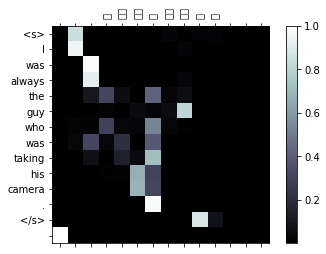

In [56]:
showAttention(input_sentence,sample_output,sample_attention)